# Table of Contents
 <p><div class="lev1 toc-item"><a href="#载入黄山数据" data-toc-modified-id="载入黄山数据-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>载入黄山数据</a></div><div class="lev1 toc-item"><a href="#黄山各点数据量" data-toc-modified-id="黄山各点数据量-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>黄山各点数据量</a></div><div class="lev1 toc-item"><a href="#VAR模型例子" data-toc-modified-id="VAR模型例子-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>VAR模型例子</a></div><div class="lev1 toc-item"><a href="#应用VAR" data-toc-modified-id="应用VAR-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>应用VAR</a></div><div class="lev1 toc-item"><a href="#LSTM预测" data-toc-modified-id="LSTM预测-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>LSTM预测</a></div>

# 载入黄山数据

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import sparse
%matplotlib inline
plt.style.use('ggplot')
import datetime
import os

pd.set_option('display.width', 200)
dir_path = os.path.dirname(os.getcwd())

os.chdir(dir_path+'/info')
#载入ap点位
ap = pd.read_csv('AP.csv', encoding='gbk')
ap.location = ap.location.astype(str)
#不同区域的代码
area = pd.read_csv('area.csv', encoding='gbk')
area.area = area.area.astype(str)
ap = pd.merge(ap, area).sort_values('ap_seq')
ap_reduce = ap.loc[:,['ap_seq','area_id']]

#import经过整理的vendor
vendor = pd.read_csv('oui.csv', encoding='gbk')
vendor.columns = ['mac6', 'vendor']
vendor['vendor'] = vendor.vendor.str.replace('"', '')
vendor['mac6'] = vendor.mac6.str.upper()
v_names = ['Apple', 'Xiaomi', 'Samsung', 'Huawei', 'Motorola', 'Microsoft', 'Oppo', 'H3C', 'Aruba', 'TP-LINK', 'D-Link', 'zte',
           'Murata', 'MEIZU', 'Intel', 'vivo', 'Hon Hai', 'HTC', 'Lenovo Mobile', 'Cisco', 'Ereneben', 'AzureWave', 'ASUSTek',
           'Sony Mobile', 'Liteon', 'LG Electronics', 'Nokia', 'Amazon', 'OnePlus', 'SYNTECH (HK)', 'Gionee', 'Smartisan', 'BBK',
           'Yulong', 'Qiku', 'Hisense', 'Tenda', 'Jing Ren', 'Wistron', 'Doukan', 'InPro', 'Dell', 'Net Com', 'Bilian', 'EASY3CALL',
           'Lemobile', 'Airgo', 'Wingtech', 'Paragon', 'Ruckus Wireless', 'RF-LINK', 'Le Shi Zhi Xin', 'Hui Zhou Gaoshengda', 
           'HIWIFI', 'Chicony', 'Beijing SHENQI', 'SYNTECH', 'AMPAK', 'private', 'LONGCHEER', 'TCT']
for name in v_names:
    vendor['vendor'] = np.where(vendor.vendor.str.contains(name, case=False), name, vendor.vendor)
'''
device_name = ['H3C', 'Aruba', 'TP-LINK', 'D-Link', 'Intel', 'Hon Hai', 'Cisco', 'AzureWave', 'Liteon', 
               'SYNTECH (HK)', 'Tenda', 'Jing Ren', 'Wistron', 'Doukan', 'InPro', 'Net Com', 'Bilian', 'EASY3CALL',
                'Lemobile', 'Airgo', 'Wingtech', 'Paragon', 'Ruckus Wireless', 'RF-LINK', 'Le Shi Zhi Xin', 'Hui Zhou Gaoshengda',
                'HIWIFI', 'Chicony', 'Beijing SHENQI', 'SYNTECH', 'AMPAK', 'private']
'''
mobile_name = ['Apple', 'Murata', 'Xiaomi', 'Huawei', 'Samsung', 'Oppo', 'vivo', 'MEIZU', 'Yulong', 'zte', 
               'Sony Mobile', 'BBK', 'Lenovo Mobile', 'HTC', 'Smartisan', 'LG Electronics', 'Qiku', 'Microsoft', 'Gionee', 
               'TCT', 'OnePlus', 'LONGCHEER', 'Hisense', 'Motorola', 'Nokia']
vendor['mobile']=np.where(vendor.vendor.isin(mobile_name), True, False)

/Users/zhangyu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.


In [82]:
#载入数据
tw_span = 10
files = os.listdir(dir_path+'/CleanData')
data = []
fileMax = 100
fileCnt = 0
for datafile in files:
    path = dir_path + '/CleanData/' + datafile
    frame = pd.read_csv(path, encoding='gbk')                 
    data.append(frame)
    fileCnt += 1
    if fileCnt >= fileMax:
        break
data = pd.concat(data, ignore_index = False)
data['date'] = pd.to_datetime(data.date)
data['tw_all'] = ((data.date-data.date.min())/pd.Timedelta(days=1)*(24*60/tw_span)+data.tw).astype(int)
del data['Unnamed: 0']
data['mac6'] = data.mac.str[:6]
data = pd.merge(data, vendor, on='mac6')
data = pd.merge(data, ap_reduce, on='ap_seq')
s = ['2','6','A','E']
data['randMac'] = data.mac.str[1].isin(s)
data = data[-data.randMac]
m_data = data[data.mobile==True]

In [83]:
#去掉只在新国线或索道下站出现的mac (mac数量从184016下降到151251)
temp = m_data[m_data.ap_seq.isin([1,2,3,14,15,18])==False]
mac = temp.groupby(['mac','date']).apply(len).reset_index(name='cnt').groupby('mac').apply(len).reset_index(name='day_cnt')
location = temp.groupby(['mac','ap_seq']).apply(len).reset_index(name='cnt').groupby('mac').apply(len).reset_index(name='location_cnt')
mac = pd.merge(mac, location, on='mac')
g_data = m_data[m_data.mac.isin(mac.mac)]
g_data['weekday'] = g_data.date.dt.weekday < 5
g_data = g_data.sort_values(['mac','tw_all'])

/Users/zhangyu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [84]:
#去掉工作人员
data_temp = g_data.groupby(['mac','date']).apply(len).reset_index()
data_temp = data_temp.groupby('mac').apply(len).reset_index(name='cnt')
staff = data_temp[data_temp.cnt > 7]
staff_mac = staff.mac
g_data = g_data[g_data.mac.isin(staff_mac) == False]

In [85]:
#标记春节
def festival(frame):
    if (frame.date.iloc[0] > pd.to_datetime('2017-01-26 00:00:00')) and (frame.date.iloc[0] < pd.to_datetime('2017-02-03 00:00:00')):
        frame['festival'] = True
    else:
        frame['festival'] = False
    return frame
g_data = g_data.groupby('date').apply(festival)
g_data = g_data[['date','mac','tw','tw_all','vendor','area_id','weekday','festival']]

# 黄山各点数据量

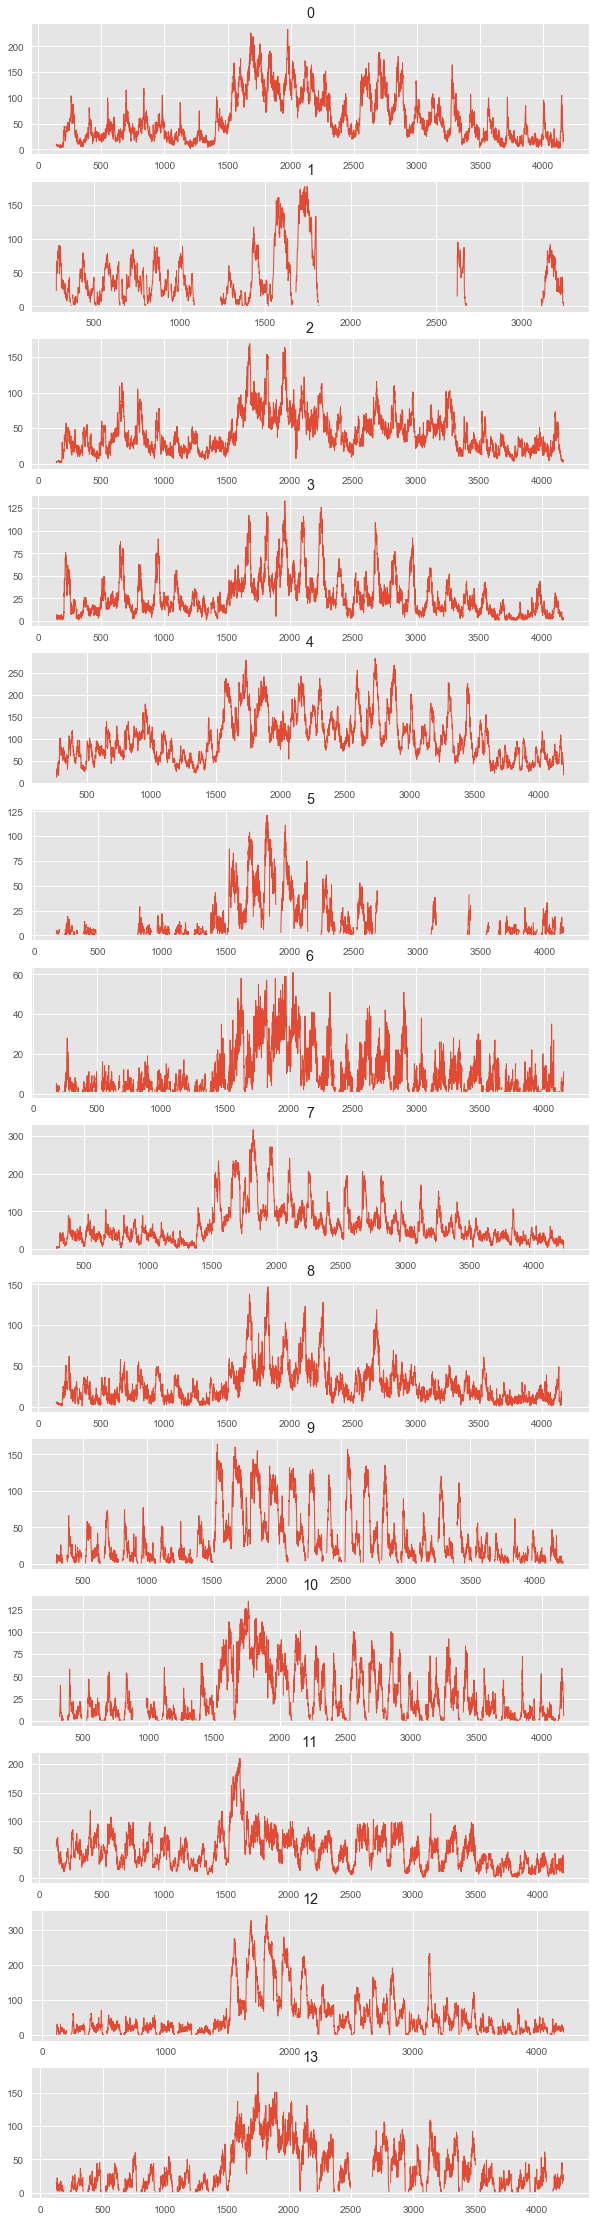

In [96]:
def draw_flow(data, figsize=(10,40)):
    fig = plt.figure(figsize=figsize)
    for i in range(14):
        ax = fig.add_subplot(14,1,i+1)
        data_temp = data[data.area_id == i]
        data_temp = data_temp.groupby('tw_all').apply(len).reset_index(name='cnt')
        tw_all = pd.DataFrame(np.arange(1,data.tw_all.max()+1))
        tw_all.columns = ['tw_all']
        data_temp = pd.merge(tw_all, data_temp, on='tw_all', how='left')
        data_temp.fillna(0)
        ax.plot(data_temp.tw_all, data_temp.cnt, linewidth=1)
        ax.set_title(str(i))

draw_flow(g_data)

In [87]:
data_b_festival = g_data[g_data.date > pd.to_datetime('2017-01-19')]
data_b_festival = data_b_festival[data_b_festival.date < pd.to_datetime('2017-01-27')]

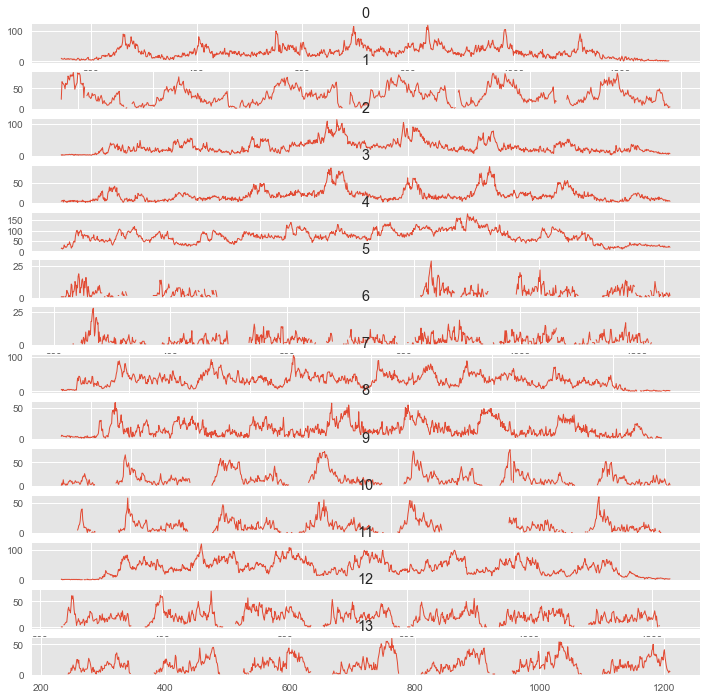

In [97]:
draw_flow(data_b_festival,figsize=(12,12))

In [89]:
def get_train_data(data):
    tw_min = data.tw_all.min()
    tw_max = data.tw_all.max()
    tw_frame = pd.DataFrame(np.arange(tw_min, tw_max+1))
    tw_frame.columns = ['tw_all']
    for i in range(14):
        data_temp = data[data.area_id == i]
        data_temp = data_temp.groupby('tw_all').apply(len).reset_index(name='cnt'+str(i))
        tw_frame = pd.merge(tw_frame, data_temp, on='tw_all', how='left')
    return tw_frame

In [90]:
train_data = get_train_data(data_b_festival)
train_data = train_data.fillna(0)
train_data = train_data.set_index('tw_all')
#删掉area_id 5
del train_data['cnt5']
train_data = np.array(train_data)

# VAR模型例子

In [135]:
import statsmodels.api as sm
from statsmodels.tsa.api import VAR, DynamicVAR
mdata = sm.datasets.macrodata.load_pandas().data

# prepare the dates index
dates = mdata[['year', 'quarter']].astype(int).astype(str)
quarterly = dates["year"] + "Q" + dates["quarter"]
from statsmodels.tsa.base.datetools import dates_from_str
quarterly = dates_from_str(quarterly)

mdata = mdata[['realgdp','realcons','realinv']]
mdata.index = pd.DatetimeIndex(quarterly)
data = np.log(mdata).diff().dropna()

# make a VAR model
model = VAR(data)

In [136]:
results = model.fit(2)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 09, Dec, 2017
Time:                     23:47:47
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -27.5830
Nobs:                     200.000    HQIC:                  -27.7892
Log likelihood:           1962.57    FPE:                7.42129e-13
AIC:                     -27.9293    Det(Omega_mle):     6.69358e-13
--------------------------------------------------------------------
Results for equation realgdp
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.001527         0.001119            1.365           0.174
L1.realgdp         -0.279435         0.169663           -1.647           0.101
L1.realcons         0.675016         0.131285            5.142    

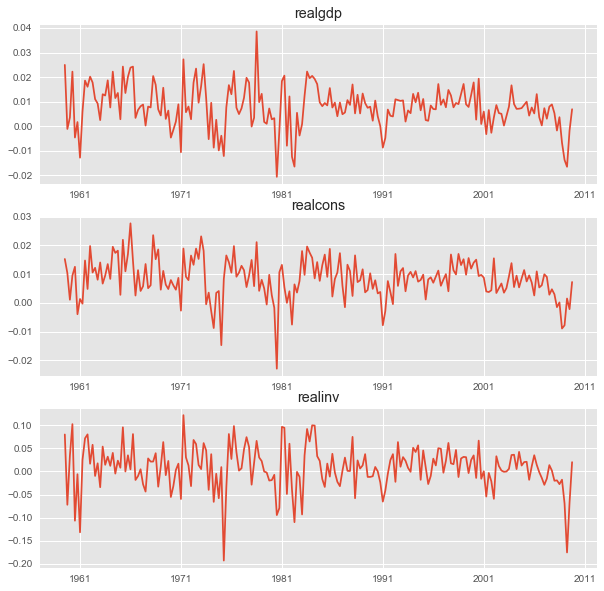

In [137]:
results.plot()

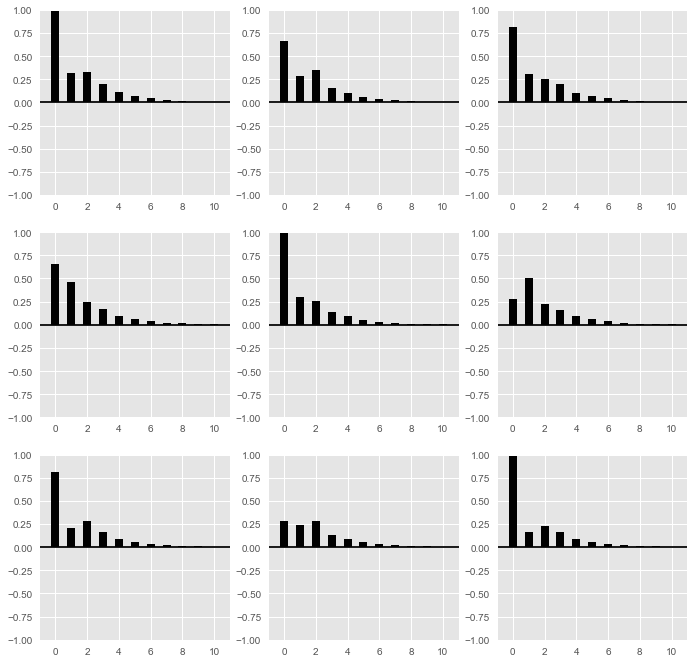

In [138]:
results.plot_acorr()

In [139]:
model.select_order(15)

                 VAR Order Selection                  
            aic          bic          fpe         hqic
------------------------------------------------------
0        -27.70       -27.65    9.358e-13       -27.68
1        -28.02      -27.82*    6.745e-13      -27.94*
2        -28.03       -27.66    6.732e-13       -27.88
3       -28.04*       -27.52   6.651e-13*       -27.83
4        -28.03       -27.36    6.681e-13       -27.76
5        -28.02       -27.19    6.773e-13       -27.69
6        -27.97       -26.98    7.147e-13       -27.57
7        -27.93       -26.79    7.446e-13       -27.47
8        -27.94       -26.64    7.407e-13       -27.41
9        -27.96       -26.50    7.280e-13       -27.37
10       -27.91       -26.30    7.629e-13       -27.26
11       -27.86       -26.09    8.076e-13       -27.14
12       -27.83       -25.91    8.316e-13       -27.05
13       -27.80       -25.73    8.594e-13       -26.96
14       -27.80       -25.57    8.627e-13       -26.90
15       -

{'aic': 3, 'bic': 1, 'fpe': 3, 'hqic': 1}

In [141]:
results = model.fit(maxlags=15, ic='aic')

lag_order = results.k_ar
results.forecast(data.values[-lag_order:], 5)

array([[ 0.00616044,  0.00500006,  0.00916198],
       [ 0.00427559,  0.00344836, -0.00238478],
       [ 0.00416634,  0.0070728 , -0.01193629],
       [ 0.00557873,  0.00642784,  0.00147152],
       [ 0.00626431,  0.00666715,  0.00379567]])

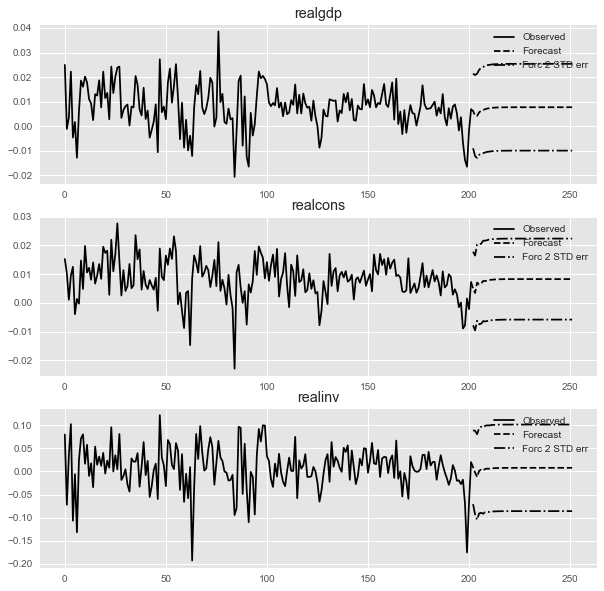

In [146]:
results.plot_forecast(50)

# 应用VAR

In [154]:
model = VAR(train_data)

In [155]:
result = model.fit(10)

In [156]:
result.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 10, Dec, 2017
Time:                     00:00:37
--------------------------------------------------------------------
No. of Equations:         13.0000    BIC:                    51.4210
Nobs:                     1142.00    HQIC:                   46.7427
Log likelihood:          -44431.9    FPE:                1.18339e+19
AIC:                      43.9043    Det(Omega_mle):     2.88415e+18
--------------------------------------------------------------------
Results for equation y1
             coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------
const          -0.254618         0.581256           -0.438           0.661
L1.y1           0.841507         0.031238           26.939           0.000
L1.y2           0.037261         0.031799            1.172           0.242
L1.y3       